# Compressing CryptoPunks
**Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization**

Gruppemedlemmer: 10047, 10095, 10100

Assume we grab our dearest friends and build the lego Death Star together. Anyone who is as lego-enthusiastic as us will realize that once the great plastic monument is assembled, it will be an absolute nightmare to move. It is fragile and prone to destruction to any slip up if we move the work of art by hand. Another issue is that it takes up a lot of space during the moving. We would need as least three people to carry it, or the entire backseat of a car. Those odds are not in our favor, but here is the solution: we decompose the system into its core components - the lego pieces - for easy and safe travel. However, the bricks are absolutely useless if we want to reassemble the Death Star back into its original state when we reach our destination - we also need the instruction manual. The assembled setup takes up a lot more space than its decomposed state consisting of tightly packed lego-pieces accommodated by the building manual. And no data is lost; the Death Star at my house would be the exact same one at your place, even if we break it down for the trip and reassembled it later on. This idea of splitting a system down to smaller factors without losing the information will be the primary element in our analysis of dimensionality reduction of face images by using matrix factorization.

We are given an image of different faces that we want to break down into its core components to save some space. The image is a famous NFT (Non-fungible token) which looks like the board game Guess Who - where the characters are just different compositions of the same basic attributes. The NFT is pixelated CryptoPunks with some suitable fashion style. And as in the board game, these punks also share some common details. One particular blue hat is for example seen on many heads, and some punks have clearly gone to the same hairdresser. The fully constructed faces would metaphorically be as the lego Death Star, where we want to split them into a system of key head-features (lego pieces), and another system which tells who wears what (instruction manual). And as with the lego, by combining the two components again, we will get back the original setup. This will be done by the witchcraft called mathematics.

We have our fully incorporated image of faces $A$. This is a matrix which contains all information of the color and opacity of each pixel, and therefore the entire image itself. We will split $A$ into $W$ (features) and $H$ (who wears what). A person will for example have a cowboy hat and blue eyeshadow, whereas another will wear the same type of hat, but no eyeshadow. The items are stored in $W$, and $H$ tells that both should wear the cowboy hat from $W$, but only one should have the eyeshadow - just as the instruction manual will tell us how to piece the legos from the box together. This holds true for all the faces, and if $A$ is an $m \times n$ matrix, $W$ has to be $m \times d$ and $H$ has to be $d \times n$. We will come back to how the different $d$ affects the accuracy of the results. $W$ and $H$ can be found by Non-negative Matrix Factorization and therefore $WH = A_{NMF} ≈ A$ by matrix-multiplication. $WH$ is therefore called the NMF reconstruction of $A$.

The algorithm to find $W$ and $H$ works as follows:

- Initialize $(W_0)_{ij} ∼ Unif(0, 1)$ and $(H_0)_{ij} ∼ Unif(0, 1)$

- Scale initial values $W_0 ← \sqrt{\frac{mean(A)}{d}}  W_0$ and $H_0 ← \sqrt{\frac{mean(A)}{d}} H_0$

- for $k = 1$ to $maxiter$ do

    - Update $H_{k+1} ← H_k ⊙ W_{k}^T A ⊘ (W_{k}^T W_k H_k + δ)$
    
    - Update $W_{k+1} ← W_k ⊙ A H_{k+1}^T ⊘ (W_k H_{k+1}H_{k+1}^T + δ)$
    
- end for

It would be impossible to guess which elements in $W$ and $H$ gives the perfect $A$ on the first try. The algorithm is therefore a way to several times refine which components are best suited for reconstructing the original image, hence updating the values in the two matrices until a good enough result is given. This is the magic of mathematics.

There are some symbols that need clarification:

- $Unif(0, 1)$: we initialize $W$ and $H$ with some values drawn from a uniform distribution between $0$ and $1$

- $maxiter$: number of maximum iterations

- $⊙$: elementwise product (else regular matrix multiplication)

- $⊘$: elementwise division

- $^T$: transpose of a matrix

- $δ$: to avoid division by zero, a number between $10^{-9}$ and $10^{-6}$

We need to look as some core aspects of the Lee\-Seung algorithm before we move on to the actual image. Then we will apply it to the NFT image, and finally do some de\-noising. Let's start by importing the relevant libraries.


In [1]:
import random
import numpy as np
from IPython.display import Latex, display, Math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
%pip install opencv-python
import cv2

import os
import time

newparams = {'figure.figsize': (8, 8), 'axes.grid': False,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

Note: you may need to restart the kernel to use updated packages.


## Functions

Secondly we define the relevant functions for our calculations and data presentation. These functions include `load_images()` to load the images of CryptoPunks as a 4D array with RGBA-values of N images, `plotimgs()` to plot some of the images using `plt.imshow()` in a grid, `fro_norm()` to calculate the Frobenius norm of the difference between two matrices, `print_matrix()` to present matrices in a nice manner and `LeeSeungsNMF()` to fit an NMF to a matrix using the algorithm describes in the pseudo code above. Finally, a function to add normally distributed error to the images is needed for task 3, `add_noise()`

In [43]:
# Code for loading images
def load_images(N):

    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded.
    INPUT:
    N:          integer, number of images to load
    -----------------------------------------------
    Output:
    faces:      (24,24,4,N) numpy array, containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):

    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    INPUT:
    imgs:         (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
    nplot:        integer, nplot**2 images will be plotted
    rescale:      bool
    filename:     string, figure will be saved to this location. Should end with ".png".
    """

    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

# Calculating the Frobenius norm
def fro_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Printing a matrix in a nice fashion
def print_matrix(array, name):
    matrix = ""
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(name+'='+r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

def LeeSeungsNMF(A, d, delta, maxiter = 1000, norm_array = False):

    """
    INPUT:
    A:          matrix, all ≥ 0 elements
    d:          integer, number of elements in A
    delta:      float, to avoid divisiion by 0
    maxiter:    integer, maximun number of iterations
    norm_array: boolean, to keep track of norms for each step
    ------------------------------------------------
    OUTPUT:
    W:          matrix, W after max iterations
    H:          matrix, H after max iterations
    norm_arr:   array, list of norms for each step
    """

    m = len(A)
    n = len(A[0])

    W = np.random.uniform(0.0, 1.0, size=(m, d))      # Initializing W_0 with values drawn from uniform distribution
    H = np.random.uniform(0.0, 1.0, size=(d, n))      # Initializing H_0 with values drawn from uniform distribution

    W = W*np.sqrt(np.mean(A)/d)           # Scaling initial values for W and H
    H = H*np.sqrt(np.mean(A)/d)

    if norm_array is True:                # If we want to keep track on the norms
        norm_arr = np.zeros(maxiter+1)    # Creating the list
        norm_arr[0] = fro_norm(A, W @ H)  # Initializing first element

    for k in range(1, maxiter+1):             # The main algorithm, * for element mulitplication, / for element division, @ for matrix multiplication
        H = H*(W.T@A)/(W.T@W@H + delta)
        W = W*(A@H.T)/(W@H@H.T + delta)

        if norm_array is True:
            norm_arr[k] = fro_norm(A, W @ H)

    if norm_array is True:
        return H, W, norm_arr             # Also returns the norm-array only if it's necessary

    return H, W

def add_noise(imgs_reshaped, sigma = 0.1):

    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    INPUT:
    imgs_reshaped:         (1728,N) numpy array
    sigma:                 scalar, noise level
    -------------------------------------------
    OUTPUT:
    noisy_faces:           (1728,N) numpy array, containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

## Task 1a

Let us now look as the aspects of the Lee-Seung algorithm. We need to prove that $W_k$ and $H_k ≥ 0$ for all $W_0 > 0$ and $H_0 > 0$, and initialize the system as follows:
$$
    A \geq 0 \newline
    W_0,H_0 > 0 \newline
    \delta > 0,
$$
where $A \geq 0$ implies that $A_{i,j} \geq 0,\; \forall \; i,j \in \mathbb{N}$.

Then,
$$
    W_0^TA \geq 0 \newline
    H_0\odot W^T_0A \geq 0 \newline
    W_0^TW_0 > 0 \newline
    (W_0^TW_0H_0 +\delta) > 0 \newline
    \Rightarrow \; H_1 = (H_0\odot W_0^TA)\oslash (W_0^TW_0H_0 +\delta) \geq 0.
$$
An equivalent argument can be made for $W$:
$$
    AH_1^T \geq 0 \newline
    W_0\odot AH_1^T \geq 0 \newline
    (W_0H_1H^T_1 + \delta) > 0 \newline
    \Rightarrow \; W_1 = (W_0\odot AH_1^T)\oslash (W_0H_1H_1^T +\delta) \geq 0.
$$
We can now see that even if $W_0,H_0 \geq 0, \; W_1,H_1 \geq 0$ would still be the case, and therefore we can easily generalize  this as follows:
$$
    A \geq 0 \wedge H_0, W_0 > 0 \newline
    \Rightarrow W_k, H_k \geq 0 \newline
$$

## Task 1b

$H_{k+1} = H_k$ only when $WH = A$, this can be proven from the algortithm.

If we exclude the safety function of the $\delta$ $\left(\delta = 0 \right)$, and assume $W^TA \neq 0$ then:
$$
    H_{k+1} = H_k \odot W^T_kA \oslash (W_k^TW_kH_k),
$$
and if $WH = A$:
$$
    H_{k+1} = H_k \odot W^T_kA \oslash (W_k^TA) = H_k \odot J,
$$
where $J$ is a matrix consisting entirely of ones. Therefore:
$$
    H_{k+1} = H_k \Leftrightarrow WH = A
$$
We will now show this numerically:

In [44]:
n_1b = np.random.randint(5, 10)     # Number of rows in A
m_1b = np.random.randint(5, 10)     # Number of columns in A

A_1b = np.random.randint(0, high=10, size=(n_1b, m_1b))     # Creating A with random numbers

d_1b = 5
delta = 1e-6
maxiter_1b = 100

H_1b, W_1b = LeeSeungsNMF(A_1b, d_1b, delta, maxiter_1b)

A_approx = W_1b @ H_1b
J = (W_1b.T@A_approx)/(W_1b.T@W_1b@H_1b)

H_display = print_matrix((H_1b-H_1b*J), r"H_k-H_{k+1}")
J_display = print_matrix(J.round(3), "J")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

By choosing $A = WH$, and then printing the difference $H_k-H_{k+1}$ we see that all elements are either zero or roundoff error. We also show that the $J$ matrix has elements equal to $1$.

## Task 1c

If $W_0,H_0 = 0$ then:
$$
    H_{1} = H_0 \odot W^T_0 A \oslash (W_0^TW_0H_0 + \delta) = \textbf{0}_{d\times n}, \newline
    W_{1} = W_0 \odot AH^T_1 \oslash (W_0H_1H_1^T + \delta) = \textbf{0}_{m\times d}
$$
where $\textbf{0}_{m\times n}$ is the matrix containing only zeros.

This is obviously a problem as $W$ and $H$ never changes, and certainly not coverge to $A$.

As an extention of this we can tackle the problem of only one of either $H$ or $W$ equaling the zero matrix. If we have a look at the algorithm and choose $H_0 = 0$ we see that $H_{1} = 0$, and therefore $W_{1}$ as well. If we choose the opposite, $W_0 = 0$, we end up with the same result.

## Task 1d

We are now ready to test our implementation of the algorithm. For this we use four arbitrarily chosen matrices $A_1$, $A_2$, $A_3$ and $A_4$. To produce a reconstruction for each matrix, we run the algorithm with a randomly generated initial matrix of same dimensions, and calculate the Frobenius norm to find how much the calculated matrix deviates from the original. The matrices used are:

$$
A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \newline
\; \newline
A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} \newline
\; \newline
A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix} \newline
\; \newline
A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix}
$$

For our first test we set $d=1$ and run the algorithm for $A_1$ and $A_2$.

In [45]:
# The arrays we will be using in this task
A1_1d = np.array([[1, 0],
                 [0, 1]])
A2_1d = np.array([[1, 2],
                  [1, 1],
                  [1, 2]])
A3_1d = np.array([[2, 1, 1],
                 [2, 1, 1],
                 [1, 1, 2]])
A4_1d = np.array([[2, 1, 0],
                 [1, 2, 3],
                 [0, 3, 3]])

# Parameters
maxiter_1d = 1000
d_1d = 1

# Fitting NMFs
H1_1d, W1_1d = LeeSeungsNMF(A1_1d, d_1d, delta, maxiter_1d)
H2_1d, W2_1d = LeeSeungsNMF(A2_1d, d_1d, delta, maxiter_1d)

# Reconstructing original matrix using W and H
NMF1_1d = W1_1d @ H1_1d
NMF2_1d = W2_1d @ H2_1d

# Displaying results
display(Latex("Results for $A_1$"))
A_display = print_matrix(A1_1d, r"A_1")
W_display = print_matrix(W1_1d, "W")
H_display = print_matrix(H1_1d, "H")
WH_display = print_matrix(NMF1_1d, "WH")
display(Latex(f"$\Vert A_1-WH \Vert _F={fro_norm(A1_1d, NMF1_1d)}$ \n"))
print()

# Displaying results
display(Latex("Results for $A_2$"))
A_display = print_matrix(A2_1d, r"A_2")
W_display = print_matrix(W2_1d, "W")
H_display = print_matrix(H2_1d, "H")
WH_display = print_matrix(NMF2_1d, "WH")
display(Latex(f"$\Vert A_2-WH \Vert _F={fro_norm(A2_1d, NMF2_1d)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

It is apparent that the calculated reconstruction of $A_1$ is quite different to the original, but this is to be expected. Because of the size of $A_1$, using $d=1$ is quite restrictive. The reason for this is that the sizes of $W$ and $H$ will not be large enough to capture all important characteristics of the original matrix. How accurate the reconstruction can be will in part depend on $d$ and the rank of the matrix in question. This we will investigate further. It is important to note that for $A_2$, the norm is a lot smaller, indicating that the size of the matrix also matters for the effectiveness of the algorithm.

## Task 1e

We will now increase the value of $d$ such that $d=2$, which we expect will yield a more accurate reconstruction because there is more opportunity for the NMF to store sufficient information about the original matrices.

In [5]:
# Parameters
d_1e = 2
maxiter_1e = 1000

# Fitting NMFs
H1_1e, W1_1e = LeeSeungsNMF(A1_1d, d_1e, delta, maxiter_1e)
H2_1e, W2_1e = LeeSeungsNMF(A2_1d, d_1e, delta, maxiter_1e)

# Reconstructing original matrix using W and H
NMF1_1e = W1_1e @ H1_1e
NMF2_1e = W2_1e @ H2_1e

# Displaying results
display(Latex("Results for $A_1$"))
A_display = print_matrix(A1_1d, r"A_1")
W_display = print_matrix(W1_1e, "W")
H_display = print_matrix(H1_1e, "H")
WH_display = print_matrix(NMF1_1e, "WH")
display(Latex(f"$\Vert A-WH \Vert _F={fro_norm(A1_1d, NMF1_1e)}$ \n"))
print()

# Displaying results
display(Latex("Results for $A_2$"))
A_display = print_matrix(A2_1d, r"A_2")
W_display = print_matrix(W2_1e, "W")
H_display = print_matrix(H2_1e, "H")
WH_display = print_matrix(NMF2_1e, "WH")
display(Latex(f"$\Vert A-WH \Vert _F={fro_norm(A2_1d, NMF2_1e)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

As expected, the error of the reconstructed matrices is significantly smaller than for $d=1$, meaning the algorithm has been much more effective. As discussed, this is because the reconstruction has the potential to identify more of the defining features of the matrix it is trying to reconstruct. Something to note here is that the reconstruction of $A_1 \in \mathbb{R}^{2\times 2}$ consists of **two** $2\times 2$ matrices, meaning that the reconstruction requires more memory than the original matrix. This deems the algorithm redundant for the purpose of reconstructing $A_1$. This also goes for the reconstruction of $A_2$; it uses more memory than the original matrix. This will in turn change when one deals with larger matrices, restoring the purpose of the algorithm; saving memory.

## Task 1f

The rank of a matrix is defined as the number of linearly independent columns in the matrix (Lindstrøm & Hveberg, 2016, s. 336). A lower rank therefore means that there are more dependant column vectors in the matrix. Storing such dependant vectors is redundant because one could in many cases perfectly reconstruct a matrix without having to store the vector more than once. One could in turn store it once, then store the information of where the vector should be seperately.

This is the idea of the algorithm we are using, where $W$ stores basis vectors and $H$ stores information about where the basis vectors should be in the reconstruction; weights if you will. Because of this, a $W$ of large enough dimension will be able, in some cases, to store **all** necessary information about $A$, such that $A = WH$; an equality rather than approximation. The dimensions of $W$ and $H$ are determined by $d$. A $d\geq rank(A)$ will in many cases be sufficient in order to perfectly reconstruct $A$, because a $d$ of this magnitude will allow $W$ to store all necessary information. This does not always happen, but as will be apparent after some tests, $d\geq rank(A)$ yields effective convergence of the reconstruction.

To investigate this, we will calculate the ranks of $A_3$ and $A_4$ to then look at how $d$ affects the precision of the algorithm when approaching the rank.

In [6]:
# Function to calculate rank of matrix
def rank(A):
    return np.linalg.matrix_rank(A)

# Calculating ranks
rank3 = rank(A3_1d)
rank4 = rank(A4_1d)

# Displaying results
display(Latex(f"$rank(A_3) = {rank3}$"))
display(Latex(f"$rank(A_4) = {rank4}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

By these results one will expect that the algorithm **can** converge towards $0$ for values $d\geq2$ for $A_3$ and $d≥3$ for $A_4$.

## Task 1g

We will now test the convergence of the algorithm for $A_3$ and $A_4$ with values $d=1,2,3,4,5$.

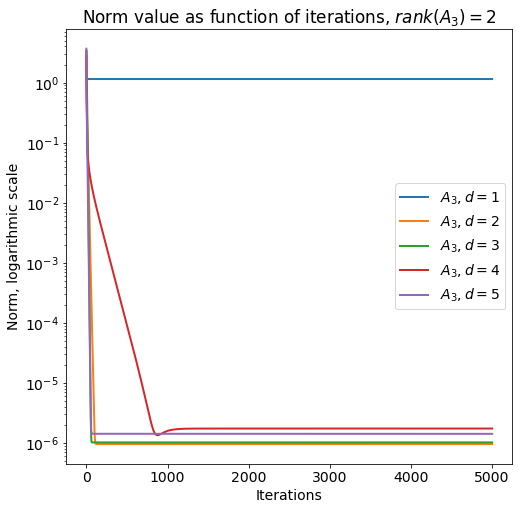

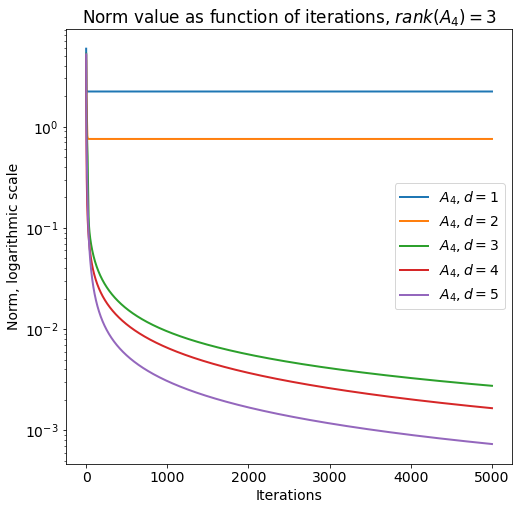

In [7]:
# Parameters
maxiter_1g = 5000

# Array of iteration count for plotting
iterations = np.arange(0,maxiter_1g+1,1)

# Initializing arrays for the norm-values
norm_arr3 = np.zeros(5, dtype = np.ndarray)
norm_arr4 = np.zeros(5, dtype = np.ndarray)

# Iterating over values of d
for d in range(1, 6):     # Iterating over the d's we want to check
    
    # Fitting NMFs
    H3_1g, W3_1g, norm3_1g = LeeSeungsNMF(A3_1d, d, delta, maxiter_1g, True)
    H4_1g, W4_1g, norm4_1g = LeeSeungsNMF(A4_1d, d, delta, maxiter_1g, True)
    
    # Storing the values of the norm for each run
    norm_arr3[d-1] = norm3_1g
    norm_arr4[d-1] = norm4_1g

# Plotting the norm as a function of iterations, A_3
plt.figure()
plt.yscale('log')
plt.title(r'Norm value as function of iterations, $rank(A_3) = 2$')
plt.plot(iterations, norm_arr3[0], label = rf'$A_3, d = 1$')
plt.plot(iterations, norm_arr3[1], label = rf'$A_3, d = 2$')
plt.plot(iterations, norm_arr3[2], label = rf'$A_3, d = 3$')
plt.plot(iterations, norm_arr3[3], label = rf'$A_3, d = 4$')
plt.plot(iterations, norm_arr3[4], label = rf'$A_3, d = 5$')
plt.xlabel('Iterations')
plt.ylabel('Norm, logarithmic scale')
plt.legend()
plt.show()

# Plotting the norm as a function of iterations, A_4
plt.figure()
plt.yscale('log')
plt.title(r'Norm value as function of iterations, $rank(A_4) = 3$')
plt.plot(iterations, norm_arr4[0], label = rf'$A_4, d = 1$')
plt.plot(iterations, norm_arr4[1], label = rf'$A_4, d = 2$')
plt.plot(iterations, norm_arr4[2], label = rf'$A_4, d = 3$')
plt.plot(iterations, norm_arr4[3], label = rf'$A_4, d = 4$')
plt.plot(iterations, norm_arr4[4], label = rf'$A_4, d = 5$')
plt.xlabel('Iterations')
plt.ylabel('Norm, logarithmic scale')
plt.legend()
plt.show()

In the plots we see a number of plateaus that are caused by the rank of the matrix being larger than $d$. A perfect reconstruction can therefore not be achieved. In contrast, as $d\geq rank(A_2)$, the reconstruction of $A_2$ converges towards the original matrix in an almost perfect manner. The fact that the leftmost graph converges towards approximately $10^{-6}$ is natural because of the fail safe $\delta$ put in to counteract division by zero, meaning that values that should be $0$ are changed to $\delta=10^{-6}$. This fail safe is also present when running the algorithm for $A_4$, but is not as apparent because the resulting NMF is not as accurate

We see clearly that the reconstruction of A gets better and better when $d \rightarrow rank(A)$, and this coincides with the expectation. However as $d > rank(A)$ we do not have a clear answer on if the solutions gets better or worse. This is because there does not exist theoretical background to say when a matrix is not prone to perfect reconstruction via NMF. Anyhow we do want to further investigate this.

In [8]:
# Creating random 10*10 matrix
A5_1g = np.random.randint(0, high=10, size=(10, 10))

# Parameters
maxiter_1g = 5000
iterations_1g = np.arange(0,maxiter_1g+1,1)
d_arr_1g = np.arange(1, 21, 1)

# Initialize array for norms
norm_arr5 = np.zeros(20, dtype = np.ndarray)

# Iterating over the d's we want to check
for i, d in enumerate(d_arr_1g):
    
    # Fitting NMF
    H5_1g, W5_1g = LeeSeungsNMF(A5_1g, d, delta, maxiter_1g)
    
    # Saving norm
    norm_arr5[i] = fro_norm(A5_1g, W5_1g @ H5_1g)

# Initialize array for average norms
norm_avg_1g = np.empty((len(d_arr_1g),1))

k = 1
while k < 100:                       # Making an array of 100 norm lists

    A6_1g = np.random.randint(0, high=10, size=(10, 10))

    if rank(A6_1g) == 10:
        norm_arr_temp = np.zeros(20, dtype = np.ndarray)
        for i, d in enumerate(d_arr_1g):                                 # Iterating over the d's we want to check
            H6_1g, W6_1g = LeeSeungsNMF(A6_1g, d, delta, maxiter_1g)               # Running the NMF algorithm
            norm_arr_temp[i] = fro_norm(A6_1g, W6_1g @ H6_1g)                               # Calculating Frobenius norm of the NMF-reconstruction
        norm_avg_1g = np.concatenate((norm_avg_1g,norm_arr_temp.reshape(20,1)), axis = -1)  # Concatenating the values in such a way that we get 100 norm values for each d
        k += 1

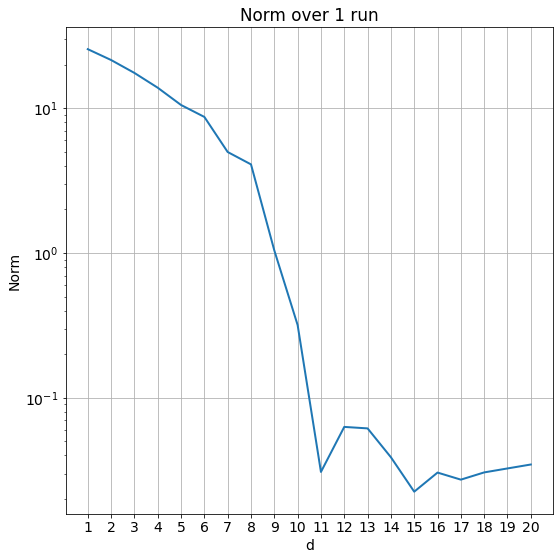

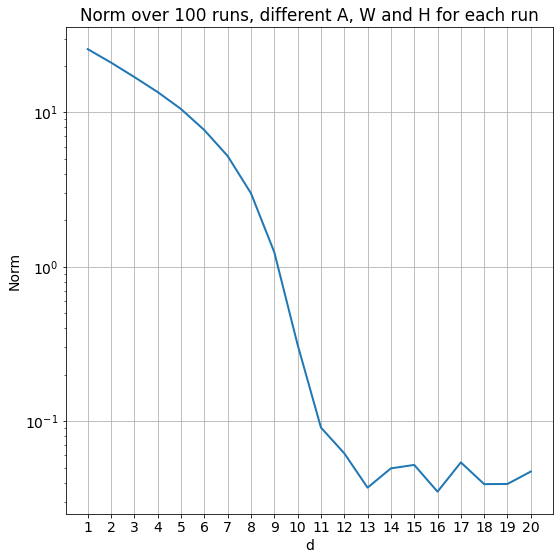

In [9]:
# Calculating mean of the norms for different values of d
norm_mean_1g = np.mean(norm_avg_1g, axis = -1)

# Plotting the norm for different values of d after one run
fig, ax = plt.subplots()
ax.set_title('Norm over 1 run')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_yscale('log')
ax.plot(d_arr_1g, norm_arr5, "")
ax.set_xticks(np.arange(min(d_arr_1g), max(d_arr_1g)+1, 1.0))
ax.set_xlabel("d")
ax.set_ylabel("Norm")
ax.grid()
ax.margins(0.05)
ax.axis('tight')
fig.tight_layout()

# Plotting the mean norm for different values of d after 100 runs
fig, ax = plt.subplots()
ax.set_title('Norm over 100 runs, different A, W and H for each run')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_yscale('log')
ax.plot(d_arr_1g, norm_mean_1g, "")
ax.set_xticks(np.arange(min(d_arr_1g), max(d_arr_1g)+1, 1.0))
ax.set_xlabel("d")
ax.set_ylabel("Norm")
ax.grid()
ax.margins(0.05)
ax.axis('tight')
fig.tight_layout()

It must be noted that since the initial matrices $W_0$ and $H_0$ are defined as $H_{0(i,j)} \sim Unif(0,1) \; \forall \; i \in [0,d], j \in [0,n] \;\wedge \; W_{0(i,j)} \sim Unif(0,1)\; \forall \; i \in [0,m], j \in [0,d]$, meaning that we use random initial matrices, the soultions here are by no means unique, but they do still represent the system (because of this we want to take the average of a hundred norms of matrices with rank $10$).

From the norm of the $100$ runs we see a clear plummit down as $d < rank(A)$. The reason for this larger error is due to a phenomenon called "underfitting". This means that the algorithm which tries to fit an NMF to the original matrix does not have the capacity to capture sufficient information about the matrix. In some sense, the reconstruction then under-represents the matrix, resulting in a greater error. After the error decreases, the graph then flattens out and oscillates in a seemingly random fashion from $d = 14$ to $d = 20$. This could indicate that random statistical error results in the small differences observed in the NMFs with $d\geq rank(A)$, which makes sense because the initial matrices are randomly generated for each run.

## Task 2a

We now turn our attention to the CryptoPunk images. As a middleground so that we have enough images to extract meaningful data but do not need too much computational power, we choose to analyse $500$ random images of CryptoPunks.

We choose to save the images in a $24 \times 24 \times 4 \times N$ array `faces`. $24 \times 24$ stems from the resolution, $4$ from the four RGBA-channels, and $N$ being the number of punks. The A in RGBA stands for "Alpha", a value that determines the opacity of the image. In the case of the CryptoPunks, the pixels of the actual punks are all of opacity $1$, while the background is of opacity $0$.



In [10]:
# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(500)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

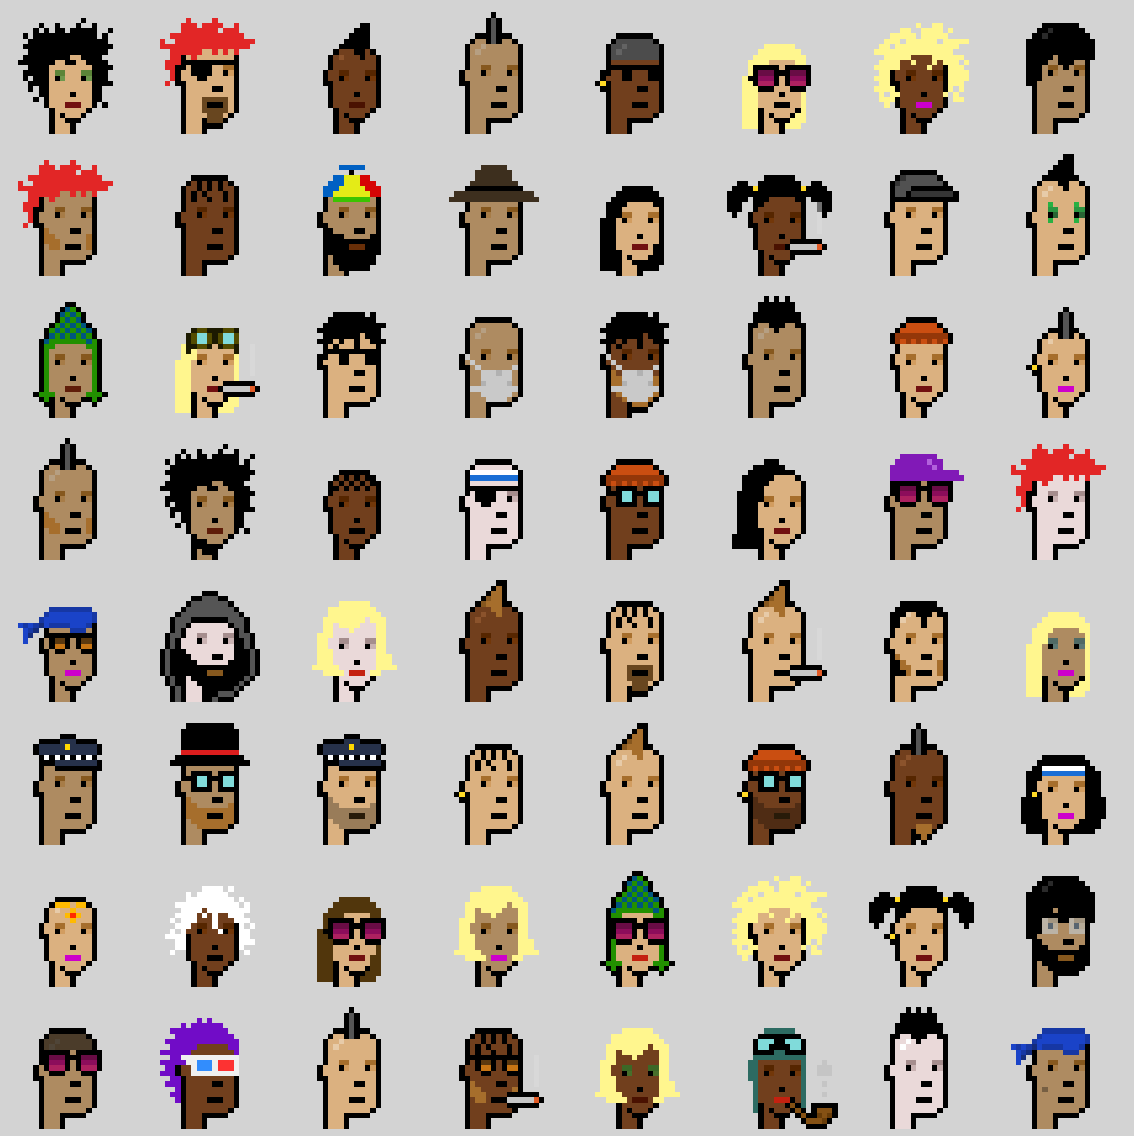

In [11]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

Here are some of the punks from the dataset. As previously stated, some key-features are seen on multiple faces, such as particular hairstyles, hats, hoods og glasses.

## Task 2b

The CryptoPunks are well suited for fitting an NMF because the characters are quite similar and very well centered in the image. This makes it so that features of interest will fall on the exact same spot of each character, making it possible for the algorithm to identify the similarities between images. To illustrate this, we will now take the average of the four channels of the images and plot the resulting image.

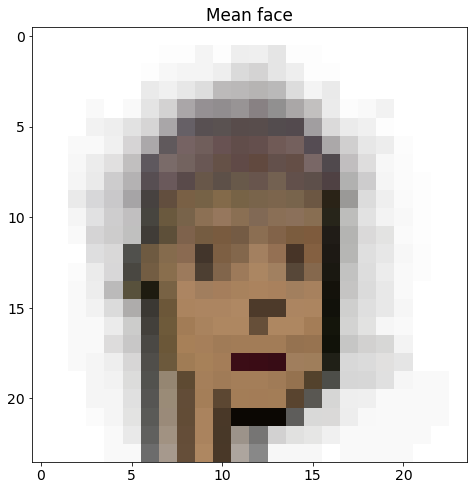

In [12]:
# Calculating mean over each channel
faces_mean = np.mean(faces, axis=-1)

# Plotting the image
plt.figure()
plt.title("Mean face")
plt.imshow(faces_mean)

The resulting face yields some useful information about the dataset. Although the mean face has no particular headgear or jewelry, it clearly shows headshape and facial structure since this is similar in almost every character. It is apparent from this plot that most faces are generally well centered since characteristics such as nose, ears, mouth and chin line up, and as expected, the mean face gives insight into basic traits. Apparels will not be very visible in the mean face, since they are scattered over a finite number of people. Alas, there are some traces of these characteristics, but with quite low opacity; e.g there are visible traces of the cigarette seen with some of the punks.

There are some pixels that have no opacity, such as the ones along the western, eastern and top side. This is because no punk has any pixels reaching that far out. One can see blurriness at the forehead, which makes sense considering that hairstyle is one of the attributes which varies the most. This results in a foggy area because it changes considerably from punk to punk.

Because there are columns and rows that are equal for every punk, the rank of the matrices will therefore be smaller than the dimension of the matrices, meaning there are rows and columns that can be removed without affecting the accuracy of a reconstruction. To get a sense of the impact of this, let us look at the R, G, B and A channels separately, and determine their ranks.

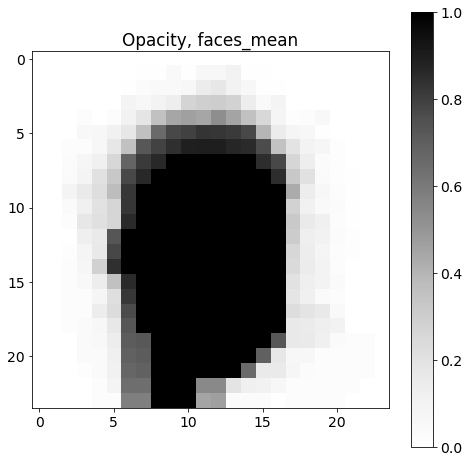

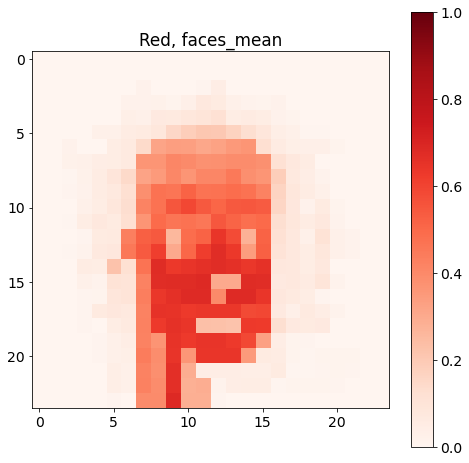

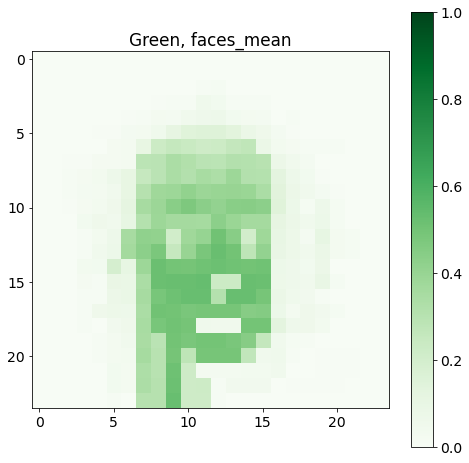

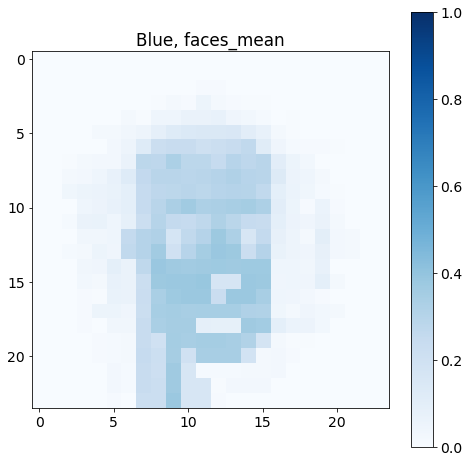

In [13]:
plt.figure()
plt.title('Opacity, faces_mean')
plt.imshow(faces_mean[:,:,3], cmap="Greys", vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('Red, faces_mean')
plt.imshow(faces_mean[:,:,0], cmap="Reds", vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('Green, faces_mean')
plt.imshow(faces_mean[:,:,1], cmap="Greens", vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('Blue, faces_mean')
plt.imshow(faces_mean[:,:,2], cmap="Blues", vmin=0, vmax=1)
plt.colorbar()

From what we can see there are no colors on the two leftmost columns, and no color in either the top row or the rightmost row in the opacity channel. This is important as rank is dependent on linearly dependent vectors (more specifically rank is the dimension of the column vector's span). Assuming these observations are correct we can determine the maximum rank of the opacity channel to be $24 - 3 = 21$. The same argument can be made for the red, green and blue channels as well.

In [14]:
# Calculating the rank of the separate channels
rank_opacity = rank(faces_mean[:,:,3])
print(f"The rank of the opacity channel:\t {rank_opacity}")

rank_red = rank(faces_mean[:, :, 0])
print(f"The rank of the red channel:\t\t {rank_red}")

rank_green = rank(faces_mean[:, :, 1])
print(f"The rank of the green channel:\t\t {rank_green}")

rank_blue = rank(faces_mean[:, :, 2])
print(f"The rank of the blue channel:\t\t {rank_blue}")

The rank of the opacity channel:	 21
The rank of the red channel:		 20
The rank of the green channel:		 20
The rank of the blue channel:		 20


The actual ranks match very well with this maximum, and the color channels are even of a rank less than this maximum. It is therefore clear that there exists information in the images that is redundant to store for a reconstruction.

## Task 2c

As we now have insight into why and how the CryptoPunks are well suited for fitting NMFs to them, it is time to put the algorithm through its paces. We start off by saving the opacity of the images, removing it from the array with pixel information, and reshaping `faces` into a $1728\times N$ array so that it is possible to fit an NMF to it. The value $d=64$ is used for fitting the NMF.

In [15]:
# Parameter
d_2c = 64

# Storing opacity channel and color channels in two seperate arrays
faces_opacity = faces[:, :, 3, :]
faces_rgb = faces[:, :, :3, :]
shape = faces_rgb.shape

# Reshaping array with color channels
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

# Fitting NMF
H_2c, W_2c = LeeSeungsNMF(faces_reshaped, d_2c, delta, maxiter=1000)

Out of curiosity we wish to study $W$ by plotting its columns which should contain the features of the characters; the basis vectors for our reconstruction. In order for `plotimgs` to be able to plot the columns, $W$ must be reshaped into an array of dimension
$24\times24\times3\times d$. It is also very possible that the algorithm produces RGB values larger than $1$, which is not compatible with `plt.imshow()`. We therefore clip the matrix by putting values larger than $1$ equal to $1$.

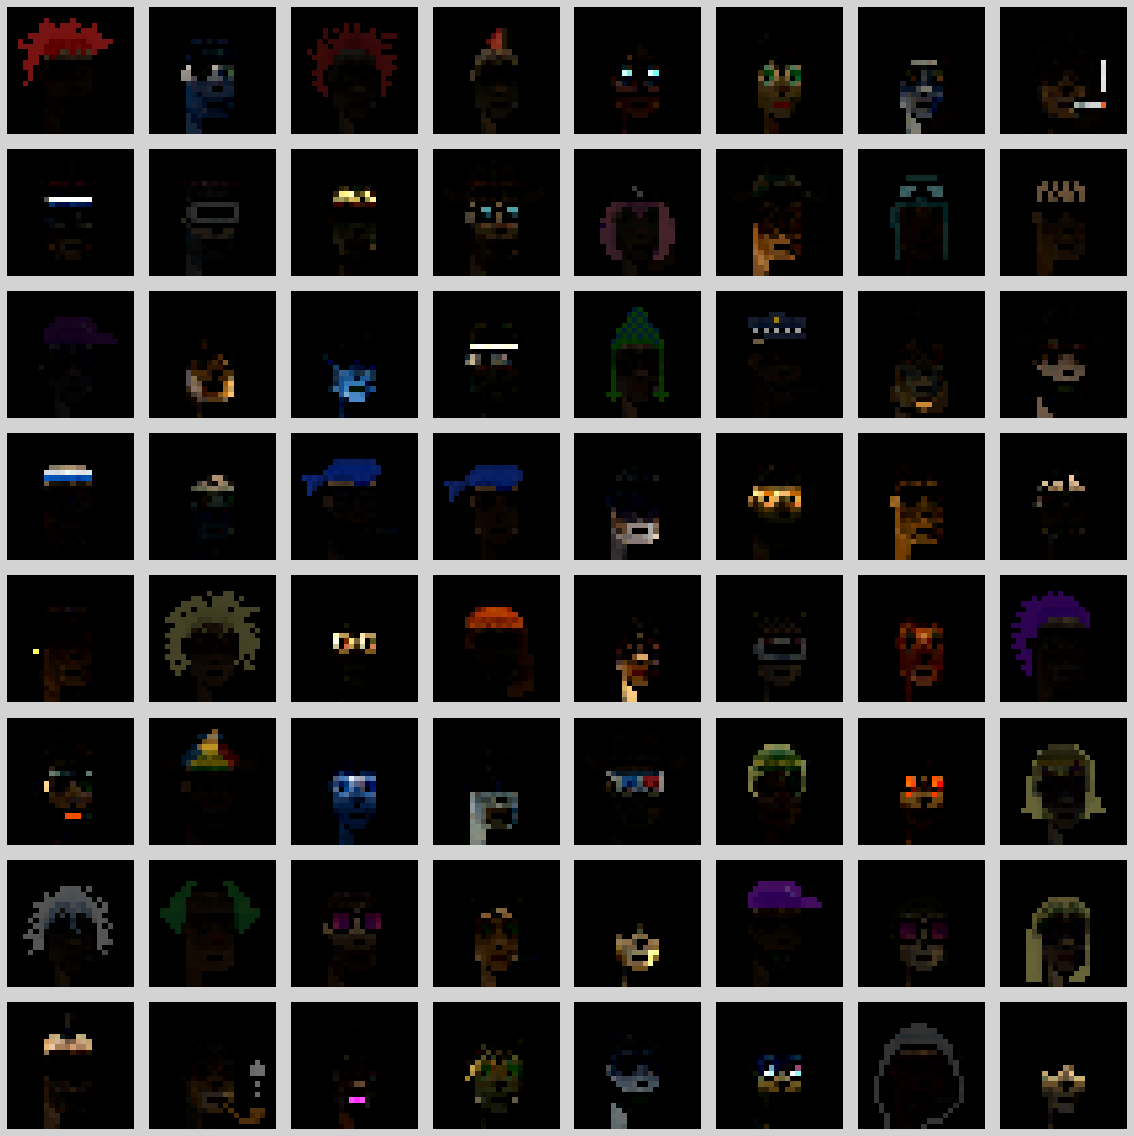

In [16]:
# Reshaping and clipping W
W_reshaped_2c = W_2c.reshape(24, 24, 3, d_2c)
W_clipped_2c = np.where(W_reshaped_2c < 1, W_reshaped_2c, 1)

# Plotting columns of W
plotimgs(W_clipped_2c, 8, filename="W_reshaped.png")

In these images we see some attributes unique to one or some characters. This makes sense as $W$, which is shown here, contains the basis elements. $H$ on the other hand contains the weights. If a figure is supposed to have 3D-glasses, but no hat, the weight of the goggles is going to be $w_{3D}\neq 0$ and $w_{Hat} = 0$, at least ideally. With this, $H$ builds the punks by assigning "importance" to each building block.

## Task 2d

It is now time to turn our attention to the actual reconstruction. This is produced by performing the matrix multiplication $WH$ given $W\in \mathbb{R}^{1728\times d}, H\in\mathbb{R}^{d\times N}$, reshaping this new array into an array of dimension $24\times24\times3\times N$, and then adding the opacity-channel. At last we plot the reconstructed images to taste the fruits of our labor.

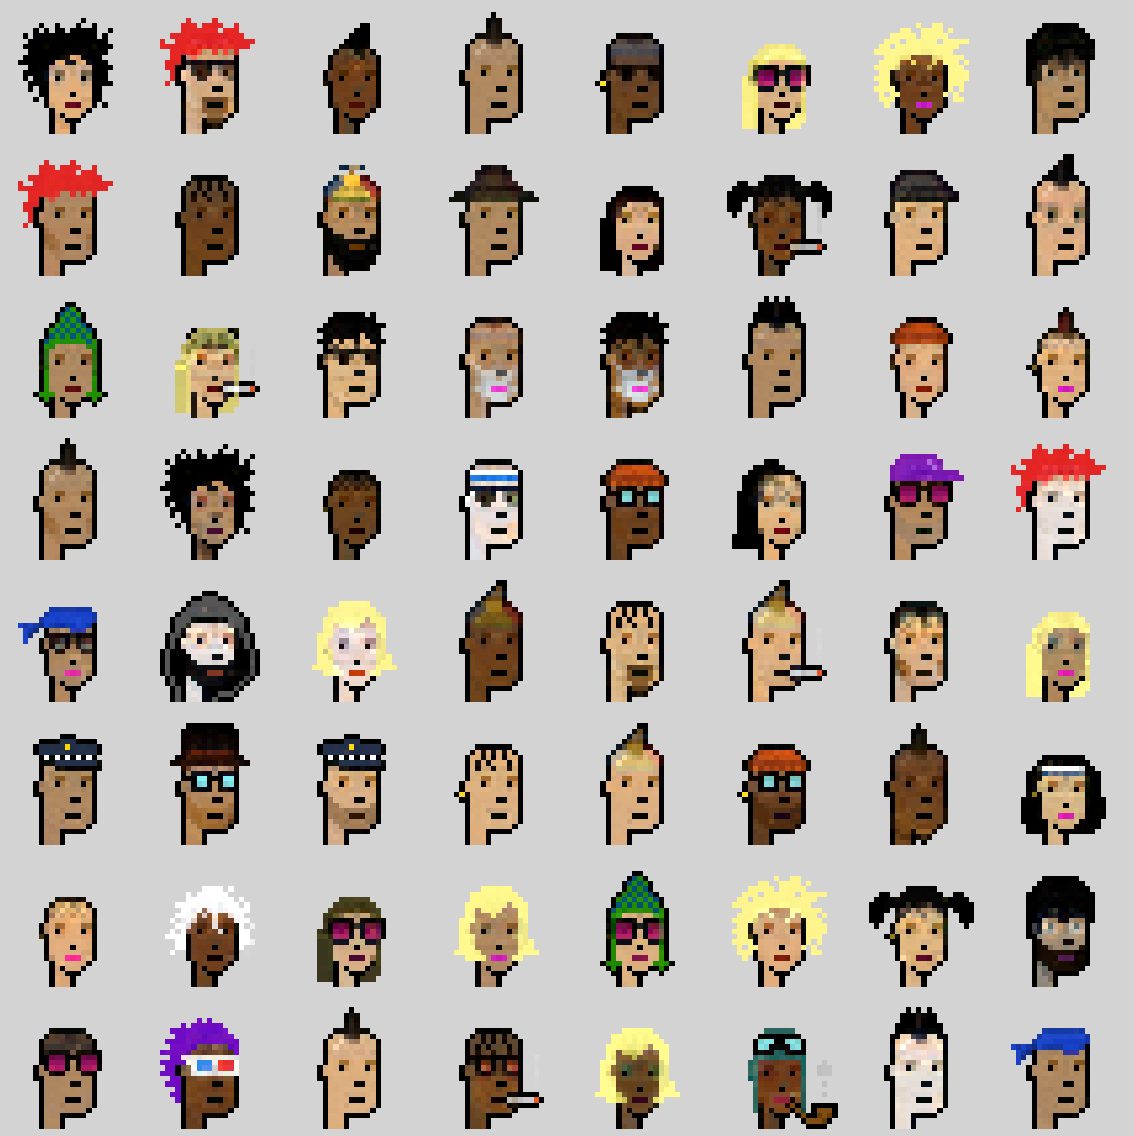

In [17]:
# Reconstructing, reshaping, clipping and adding opacity channel to NMF
NMF_2d = W_2c @ H_2c
NMF_reshaped_2d = NMF_2d.reshape(24, 24, 3, N)
NMF_clipped_2d = np.where(NMF_reshaped_2d < 1, NMF_reshaped_2d, 1)
faces_opacity = faces_opacity.reshape(24,24,1,500)
NMF_total_2d = np.concatenate((NMF_clipped_2d, faces_opacity), axis=2)

# Plotting reconstructed images
plotimgs(NMF_total_2d, 8, filename="NMF_reshaped.png")

Some inaccuracies are visible, but all in all, with $d = 64$ the figures are clearly represented! Because of $d = 64$ we have two matricies: $W \in \mathbb{R}^{1728 \times 64}$ and $H \in \mathbb{R}^{64 \times 500}$. Since the original matrix $F$ has dimension $1728 \times 500$, the new matricies only need $16.5\%$ of the elements. This saves a lot of space.

Even though the figures are well represented they are by no means perfect. You can see pieces of the other figures' attributes showing up as faint (or not so faint) "shadows" over the figure. This "noise" in the images is present because of inaccuracies in the reconstruction, which is natural as it is quite hard to reconstruct a matrix with such significantly smaller amounts of matrix-elements. We will attempt to handle this later on.

## Task 2e

As it is clear that the algorithm works and that it is reasonably effective at reproducing the images for $d=64$, we wish to investigate the impact of the magnitude of $d$. We therefore fit different NMFs to the original images with a varying $d$ and observe the evolution of $\Vert A-A_{NMF}\Vert_F$ for each value. The values $d=16,32,64$ will be used, and the algorithm will perform $1000$ iterations for each value.

In [18]:
# Parameters
d_2e = np.array([16, 32, 64])
maxiter_2e = 1000

# Initializing arrays for storing H, W and norms for each run
H_arr_2e = np.zeros(len(d_2e), dtype = np.ndarray)
W_arr_2e = np.zeros(len(d_2e), dtype = np.ndarray)
norms_2e = np.zeros(len(d_2e), dtype = np.ndarray)

# Constructing array of iterations for plotting norms
iterations_2e = np.arange(0, maxiter_2e+1, 1)

# Iterating over values of d
for i, d in enumerate(d_2e):
    
    # Fitting NMF
    H_2e, W_2e, norm_arr_2e = LeeSeungsNMF(faces_reshaped, d, delta, maxiter = maxiter_2e, norm_array = True)
    
    # Storing norm, W and H
    norms_2e[i] = norm_arr_2e
    W_arr_2e[i] = W_2e
    H_arr_2e[i] = H_2e

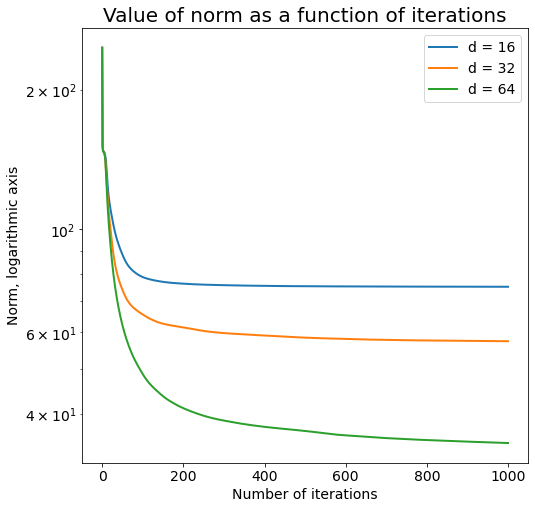

In [19]:
# Plotting norm as function of iterations for each value of d
plt.figure()
plt.yscale('log')
plt.title('Value of norm as a function of iterations', fontsize=20)
plt.plot(iterations_2e, norms_2e[0], label=f"d = {d_2e[0]}")
plt.plot(iterations_2e, norms_2e[1], label=f"d = {d_2e[1]}")
plt.plot(iterations_2e, norms_2e[2], label=f"d = {d_2e[2]}")
plt.xlabel("Number of iterations")
plt.ylabel("Norm, logarithmic axis")
plt.legend()
plt.show()

It is clear from this plot that a large value of $d$ results in the error of the reconstruction converging towards a smaller value, meaning that larger values of $d$ produce more accurate reconstructions. The reason for this is that larger matrices $W$ and $H$ have the potential to store more valuable and distinct information about the original image than smaller such matrices. Large values for $d$ requires in turn more memory. It therefore becomes important to choose a $d$ that produces adequately accurate reconstructions but does not require too much memory. By using too much memory for $W$ and $H$, one defeats the purpose of fitting an NMF to the original image.



## Task 2f

Our plot in task 2e shows that different values for $d$ converge towards different norm-values. We therefore want to look closer at the value of convergence as a function of this $d$ instead of as a function of number of iterations, to see how the accuracy of the algorithm varies with $d$. Six $d$-values are chosen, $16$, $64$, $128$, $256$, $512$, and $1024$. To ensure that the recorded value has converged, we choose a relatively high number of iterations, and we choose $1000$.

In [20]:
maxiter_2f = 1000

d_2f = np.array([16, 64, 128, 256, 512, 1024])
norm_arr_2f = np.zeros(len(d_2f))
iterations_2f = np.arange(0, maxiter_2f+1, 1)

for i, d in enumerate(d_2f):
    H_2f, W_2f = LeeSeungsNMF(faces_reshaped, d, delta, maxiter = maxiter_2f)
    NMF_2f = W_2f @ H_2f
    norm_2f = fro_norm(faces_reshaped, NMF_2f)
    norm_arr_2f[i] = norm_2f

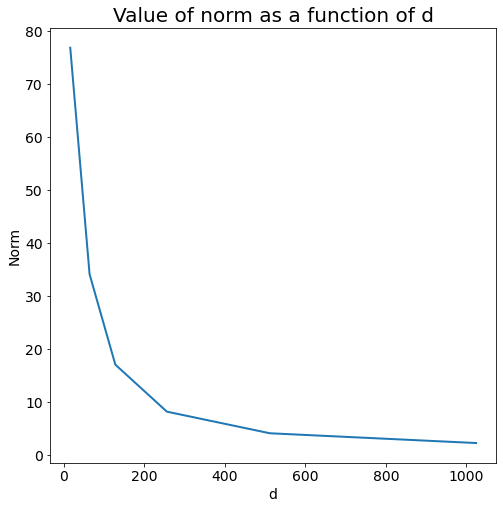

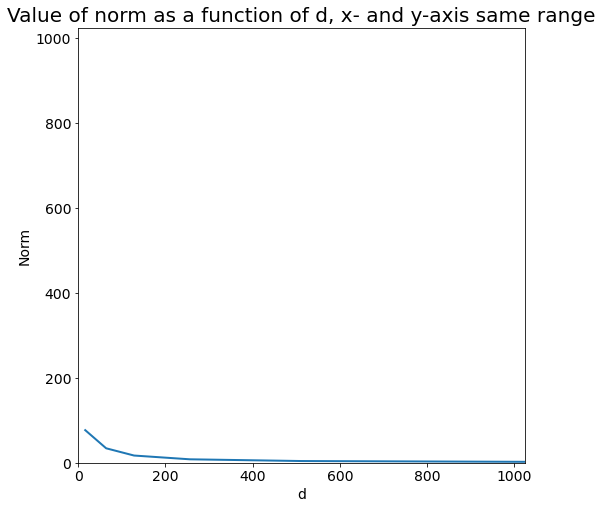

In [21]:
plt.figure()
plt.title('Value of norm as a function of d', fontsize=20)
plt.plot(d_2f, norm_arr_2f, label=f"d = {d_2f}")
plt.xlabel("d")
plt.ylabel("Norm")
plt.show()

plt.figure()
plt.title('Value of norm as a function of d, x- and y-axis same range', fontsize=20)
plt.plot(d_2f, norm_arr_2f, label=f"d = {d_2f}")
plt.xlabel("d")
plt.ylabel("Norm")
plt.xlim((0,1024))
plt.ylim((0,1024))
plt.show()

As seen above, the norm behaves as an inverse exponential function of $d$, and the norm starts off relatively high, but converges towards $0$ as $d$ increases. The size of $W$ and $H$ is therefore crucial in the accuracy of the reconstruction, and a larger size of these two will in this case give a sharper picture since the "difference" between original and reconstructed is smaller. Since the norm decreases exponentially with $d$, the derivative of this function is much smaller for large values of $d$. Consequently, there is a larger gain in accuracy for smaller values of $d$.

## Task 3a

Let us turn our attention to "de-noising". As seen in plots of our fitted NMFs, there are some inaccuracies in the reconstructions. This is what we will refer to as noise, and de-noising will therefore be the action of removing this noise. We will look at additive Gaussian noise which is on the form $A_{noisy} = A + σE$ 
where $σ > 0$ is a scalar noise level and E is a matrix with the same shape as A and its components are realizations of a standard normal distribution. This means that $A_{noisy}$ will be $A$ with a normally distributed error; the noise. We use the function `add_noise()` to add noise to a specified array of images. This new "noisy" array will be used for de-noising.

<IPython.core.display.Latex object>

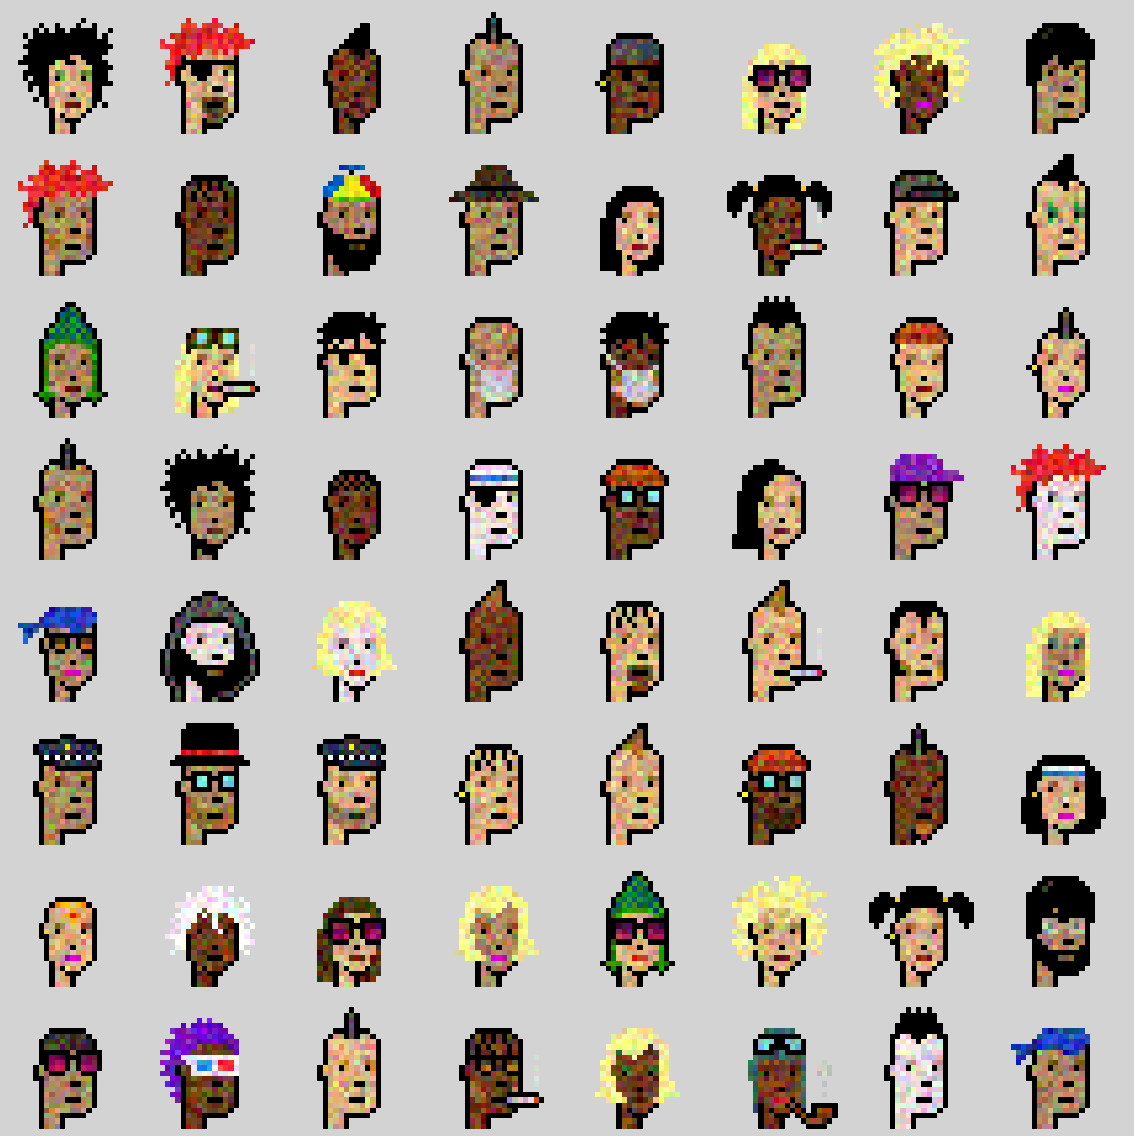

In [22]:
# Adding noise to array of images
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
display(Latex(f"$\Vert A_{{noisy}} - A \Vert_F = {noise_residual}$"))

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity = np.concatenate((noisy_faces_with_opacity, faces_opacity), axis = 2)
plotimgs(noisy_faces_with_opacity)

The punks are still clearly visible and differentiable but they are noisy and therefore have "rainbow" artifacts. Noise-wise $\sigma = 0.1$ is a high value, however this is still not so high as to obscure the punks beyond recognition.

## Task 3b

The procedure we will utilize for de-noising is to fit an NMF to the noisy images. The noise is, in essence, fine details, and the NMF-algorithm will not pick up on these details, but rather extract the basic traits of the punks. This will in turn reduce the noise.

To demonstrate this an NMF is fitted to the array of noisy punks constructed above.

In [23]:
d_3b = 64                     # d = 64 for this part

# Fitting an NMF to the noisy images
H_3b, W_3b = LeeSeungsNMF(noisy_faces, d_3b, delta, maxiter=1000)

In [24]:
# Reshaping and clipping W
W_reshaped_3b = W_3b.reshape(24, 24, 3, 64)
W_clipped_3b = np.where(W_reshaped_3b < 1, W_reshaped_3b, 1)

# Reconstructing, reshaping and clipping the punks
NMF_3b = W_3b @ H_3b
NMF_reshaped_3b = NMF_3b.reshape(faces_rgb.shape)
NMF_clipped_3b = np.where(NMF_reshaped_3b < 1, NMF_reshaped_3b, 1)
NMF_total_3b = np.concatenate((NMF_clipped_3b, faces_opacity), axis = 2)

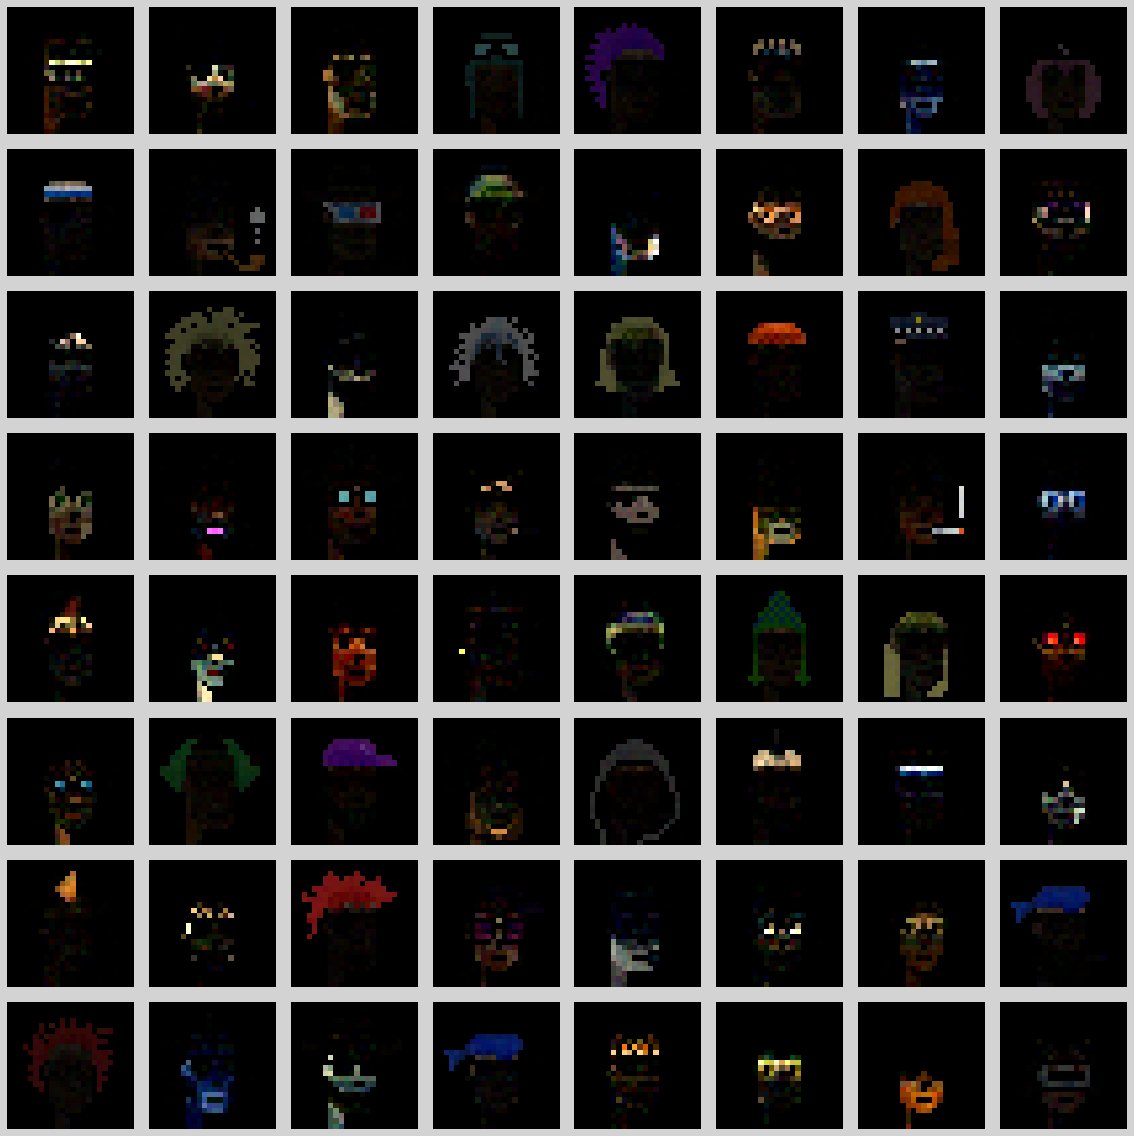

In [25]:
# Plotting the columns of W
plotimgs(W_clipped_3b)

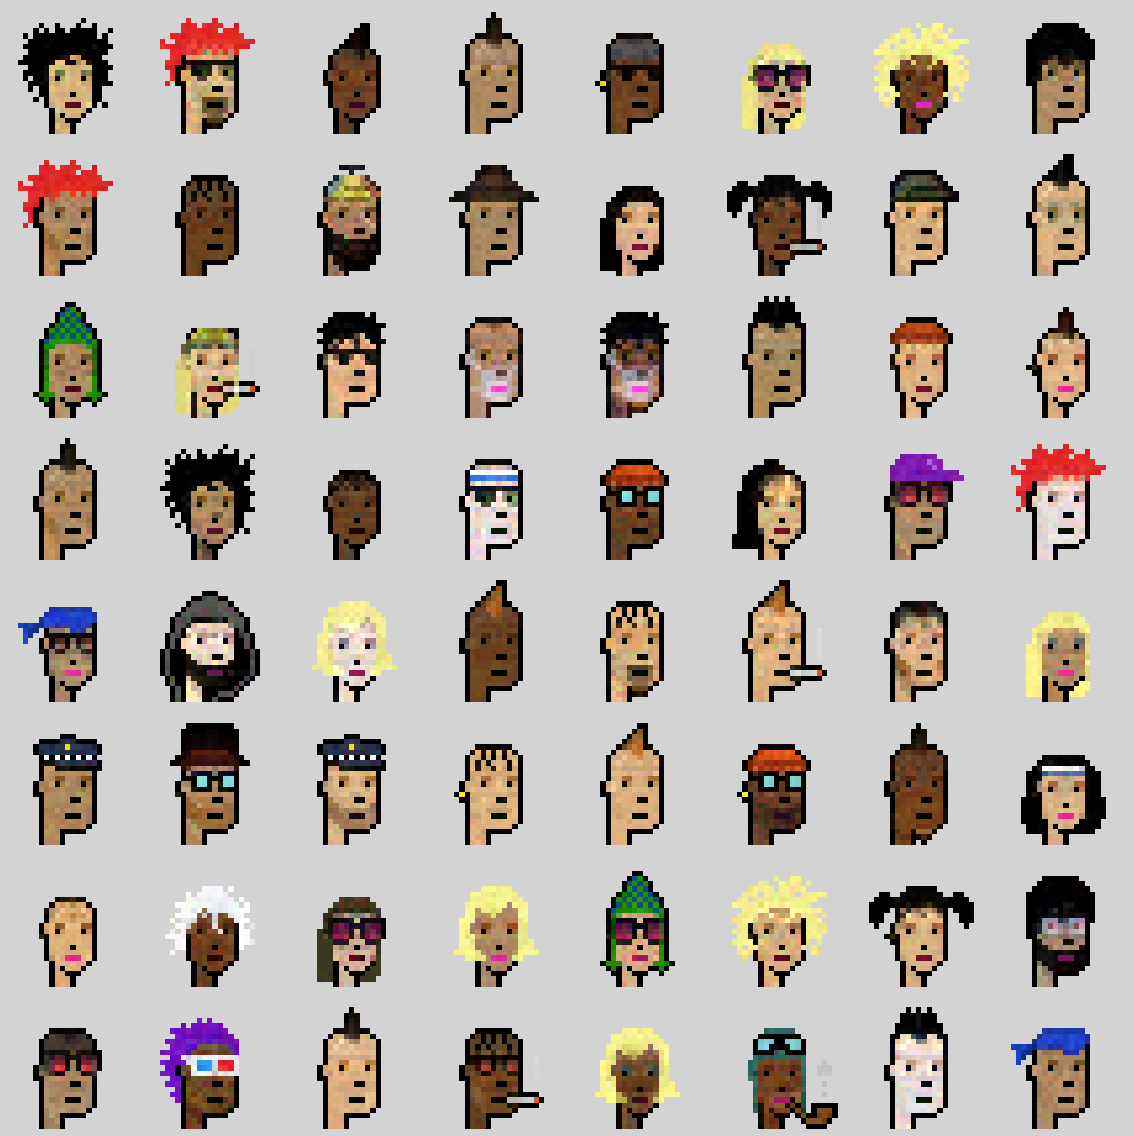

In [26]:
# Plotting the de-noised images
plotimgs(NMF_total_3b)

We see a big improvement from the noisy faces. The contrast of the "rainbow artifacts" is significantly reduced, with some punks more noisy than others. If we are to compare the noisy and de-noised images to the reconstruction from task 2c and 2d, it is apparent that the noisy image differs significantly from the original images. In contrast, the de-noised images resemble our reconstruction very well due to the reduction in noise. This means that there still are inaccuracies in the final reconstruction, e.g. the "shadow-like" attributes from other punks that are mistakenly included in some images, but the overall quality of the reconstruction has been improved by de-noising.

In order to see the effectiveness of the de-noising, we will compare the norm of the difference between the NMF from task 2d and the original images, and between the de-noised and the original images. A comparison between the $W$-matrix of the NMF and the de-noised reconstruction will also be made.

In [27]:
total_norm_2d = fro_norm(NMF_total_2d.reshape(24*24*4, 500), faces.reshape(24*24*4, 500))
total_norm_noisy = fro_norm(noisy_faces_with_opacity.reshape(24*24*4, 500), faces.reshape(24*24*4, 500))
total_norm_3b = fro_norm(NMF_total_3b.reshape(24*24*4, 500), faces.reshape(24*24*4, 500))
W_difference = fro_norm(W_clipped_2c.reshape(1728, d_2c), W_clipped_3b.reshape(1728, d_3b))

display(Latex(f"$\Vert F-A_{{NMF}}\Vert_F={total_norm_2d}$"))
display(Latex(f"$\Vert F-A_{{noisy}}\Vert_F={total_norm_noisy}$"))
display(Latex(f"$\Vert F-A_{{de-noised}}\Vert_F={total_norm_3b}$"))
display(Latex(f"$\Vert W_{{NMF}}-W_{{de-noised}}\Vert_F={W_difference}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The difference between the original and the de-noised images is about $8.3\%$ larger than that of the original and the NMF from task 2d. The difference between the original and the de-noised images is in turn around $9.0\%$ smaller than the difference between the original and the noisy images. Such a gain in accuracy from the noisy images is considerably large. This does mean that the difference between the de-noised and the original NMF is somewhat large too, but much smaller than the difference between the noisy images and the NMF. Qualitatively, the gain in accuracy is night and day, and the de-noised images resemble the NMF almost to a tee. This contrast between qualitative and quantitative results can be explained by how we as humans perceive differences in color and how the Frobenius norm calculates the same difference.

The difference between the $W$-matrices is quite large. This can be explained by the fact that specific traits are not represented in the same location in the $W$-matrices. This means that even though the same traits are captured, the positions of the traits in $W$ are very different, resulting in a large value for the norm.

## Task 3c

The next step is to do as done i task 2, where we fit an NMF to the noisy faces as a function of $d$. The resulting graph is the error $\Vert A- A_{de-noised}\Vert_F$, which we compare to the error calculated in task 2f in the same plot. As in task 2f a large range of $d$ is chosen: $d=16, 64,128,256,512,1024$ to get a good representation of how the error varies with $d$. Also here the algorithm runs for $1000$ iterations to ensure an adequate convergence

In [28]:
# Parameters
d_3c = np.array([16, 64, 128, 256, 512, 1024])
maxiter_3c = 1000

# Initialize array of norms
norm_arr_3c = np.zeros(len(d_3c))

# Running algorithm for values of d then calculating and saving value of norm
for i, d in enumerate(d_3c):
    H_3c, W_3c = LeeSeungsNMF(noisy_faces, d, delta, maxiter = maxiter_3c)
    NMF_3c = W_3c @ H_3c
    norm_3c = fro_norm(faces_reshaped, NMF_3c)
    norm_arr_3c[i] = norm_3c


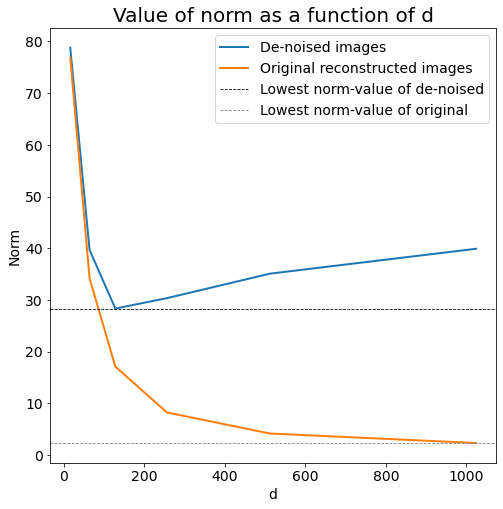

In [29]:
# Plotting
plt.figure()
plt.title('Value of norm as a function of d', fontsize=20)
plt.plot(d_3c, norm_arr_3c, label=f"De-noised images")
plt.plot(d_2f, norm_arr_2f, label=f"Original reconstructed images")
plt.axhline(y=min(norm_arr_3c),color = 'black',linestyle='--', linewidth = 0.8,label = 'Lowest norm-value of de-noised')
plt.axhline(y=min(norm_arr_2f),color = 'gray',linestyle='--', linewidth = 0.8,label = 'Lowest norm-value of original')
plt.xlabel("d")
plt.ylabel("Norm")
plt.legend()
plt.show()

In the plot we see that in contrast to the norm in 2f, this time we expirience both underfitting and overfitting. Underfitting occurs when the value of $d$ is too small resulting in a reconstruction that does not capture sufficient information about the images, resulting in a relatively large error. By increasing $d$ one eventually reaches the optimal value which is best size for de-noising. Overfitting is the phenomena that occurs when the norm rises back up for a $d$ beyond the optimal one. The reason for this is that the algorithm acquires too much information about the noisy images, meaning that the algorithm captures noise as features of the punks. The underfitting is recognized in the norm for 2f, while **both** under- and overfitting is experienced in the norm for 3c.

From the plot above it is safe to assume that the local minima around $d = 128$ is the global minima of the curve. With this assumption we can make a minimizer function. We cannot use a minimizer function like the ´scipy.optimize.minimize´ because of the fact that $d$ has to be an integer.

Something that must be noted is that the NMF-algorithm initializes $W$ and $H$ randomly each time, and therefore the norm varies from time to time, even with the same d-value. The consequence of this is that the minimizer function only will find an approximate optimal d-value.

In [30]:
def minimize_norm(d):
    H_3c, W_3c = LeeSeungsNMF(noisy_faces, d, delta, maxiter = maxiter_3c)
    NMF_3c = W_3c @ H_3c
    return fro_norm(faces_reshaped, NMF_3c)

# We have from the plot a clear contender for the minimum, and to save a one calculation we initialize with x_0 and y_0
x_0_3c = 128
y_0_3c = norm_arr_3c[2]

# This function is not optimized for space, but rather optimized for the minimum number of runs through the algorithm. It does so by utilizing a
# kind of FSAL-ability (first same as last), although this is not a numerical method in the same sense we have used this ability in the past.
def minimizer(f, x_0, y_0):
    idx = x_0
    f_comp = y_0
    f_new = f(idx+1)
    if f_new < f_comp:
        idx += 1
        f_comp = f_new
        while True:
            f_new = f(idx+1)
            if f_new < f_comp:
                f_comp = f_new
                idx += 1
            else:
                return f_comp, idx
    f_new = f(idx-1)
    if f_new < f_comp:
        idx -= 1
        f_comp = f_new
        while True:
            f_new = f(idx-1)
            if f_new < f_comp:
                f_comp = f_new
                idx -= 1
            else:
                return f_comp, idx
    else:
        return f_comp, idx

out_3c = minimizer(minimize_norm, x_0_3c, y_0_3c)

display(Latex(f'Minimum norm value: ${out_3c[0]}$, with $d = {out_3c[1]}$'))

<IPython.core.display.Latex object>

The result is as expected, around $d = 128$.

## Task 3d - Conclusion

A task of utmost importance when handling data is efficient use of memory, since storing information can be a costly affair. To omit this, methods of compressing data are used, one of these being non-negative matrix factorization, NMF, as we have studied in this report. Another area of use for this algorithm is the practice of removing so called noise in images with imperfections, in order to obtain more accurate reconstructions relative to the original. We refer to this as de-noising.

NMF aims to reconstruct a matrix $A$ by approximating it to a matrix product $WH$, where $W$ is a matrix which captures common features in $A$ and $H$ contains information about the locations of elements from $W$ in $A$. The dimensions of the matrices used in the reconstruction are defined by the dimension of the original matrix and a parameter $d$ which is chosen freely. To fit an NMF one starts off with initial matrices $W_0$ and $H_0$, which initialize iterations of the NMF algorithm. The algorithm then converges towards an approximation of $A$ which ideally saves memory.

This way of storing data has shown itself to be very efficient, but comes with some problems. With $500$ Cryptopunks, each with $24 \times 24$ pixels, and $d = 64$ (as in task 2d), we save $83.5\%$ of the matrix elements, which is a huge difference in storage space. Unfortunately imperfections occur when reconstructing the original matrix. In the case of the CryptoPunks, there are shadows of other punks' apparell, jewelry or features present where they should not be. There is no problem recognising which punk is which before and after the NMF, but it is obvious which punks are original and which are reconstructed.

While reconstructing a matrix by its reoccuring features does not result in a perfect representation, in the context of de-noising this becomes an advantage if one fits an NMF to a noisy image. The purpose of de-noising is to remove imperfections, and the algorithm does this by extracting features, like a pair of glasses. Each pair of glasses are noisy in a unique way, but because the imperfections in essence are fine details, the algorithm ideally fails to capture these details. The result is a pair of "mean-glasses" who are less noisy and can be used to reconstruct an image better than the noisy one.

With respect to difficulities choosing a suitable value for $d$, we found that it is highly dependent on the operation at hand. If the task is to utilize an NMF to compress a dataset and make it more space-efficient, the optimal $d$-value must be found with a balance of the space saved, the accuracy of the reconstruction, and the processing power available. With a $d$-value as large as possible we would get an almost perfect reconstruction, but as a consequence use more space than originally used, defeating the purpose of the reconstruction.

On the other hand, if the task is to de-noise a picture, one can encounter either over- or underfitting depending on $d$. If the value is too small the recontruction does not have enough information to accurately reconstruct the images. Also, if the value is too large the NMF captures the noise as features, and proceeds to include them in the reconstruction. The most optimal $d$ for de-noising is therefore large enough to capture the desired features of the images, but small enough so to not capture the imperfections. For the purpose of de-noising images of CryptoPunks, we found that the value $d\approx 128$ was most efficient at removing noise.


This dataset of NFTs is the best case scenario, as they seem almost tailor-made for this algorithm. A random set of pictures without the heads centered nor a limited number of features would probably neither compress nor de-noise with the same efficiency as with the CryptoPunks.

## Extra - Death Star

As this extra task is not explicitly part of this project, we wish to stress that what we are about to do is done as an extra experiment to further test the practicality of the NMF algorithm. With this in mind, we wish to further illustrate the concept of matrix factorization for a more general example where the picture is not pre-divided into chunks. We will analyse a picture of the actual lego Death Star from the opening analogy, shamelessly stolen from the internet, with the white background changed to opacity $= 0$. The same process we used for the NFT is used here as well, but we need to manually rearrange the picture-matrix into something we can work with, since the Death Star is only one single image, and not originally organized into segments as the punks were. We will manually do the partitioning, and to save any space at all we decided on $30$ chunks with $30\times 43$ pixels each. The partitioning algorithm took more brainpower than we would like to admit. With these newly made chunks acting like faces in the previous tasks, we arranged them with the alpha-channel removed on the form $30\times43\times3\times30$. We reshaped it into a $3870\times30$ and set out to decompose the picture.

Using the NMF-algorithm we obtained a $W$ and an $H$ matrix, and tested the result by multiplying them together and reassembeling the partitions into a full image.

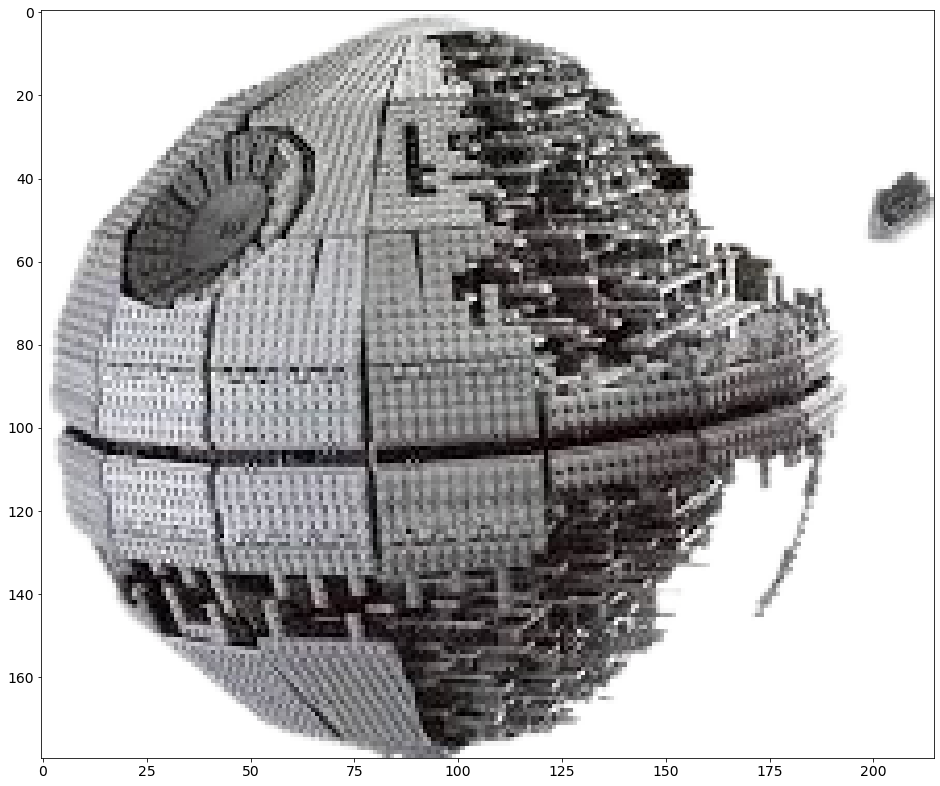

In [33]:
"""

We have used the handed out code, but done som modifications so that it only loads the one deathstar-image

"""

def load_images_deathstar():

    """
    Loads the deathstar image.
    INPUT:
    -----------------------------------------------
    Output:
    Dstar:       numpy array, containing the image
    """

    # Allocate array to store images
    Dstar = np.zeros((180,215,4))
    
    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgssun'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                Dstar[:,:,:] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0
            break
    return Dstar

def plotimgs_deathstar(imgs, rescale = False, filename = None):

    """
    Plots 30 images on an 6 x 5 grid.
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    INPUT:
    imgs:         (n,m,4,30) or (n,m,3,30) array containing images,
    rescale:      bool
    filename:     string, figure will be saved to this location. Should end with ".png".
    """

    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(6,5)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(30):
        
        # Indices
        i = idx//5; j = idx%5

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

# Load the deathstar image
Deathstar = load_images_deathstar()
plt.figure(figsize=(16,16))
plt.imshow(Deathstar)

# Saving the opacity and re moving from image array
deathopac = Deathstar[:,:,3]
deathRGB = Deathstar[:,:,:3]

Here is the image of the Death Star$^\star$ we will use. This will then undergo a partitioning to make sure it is on the form as previously stated.

In [34]:
"""
Here we partition the image into chunks
"""

deathRGBparted = np.reshape(deathRGB[0:30,0:43,:], (30,43,3,1))

print('Shape the first chunk: ', deathRGBparted.shape)
for i in range(6):
    for j in range(5):       # These nested for loops save the data in such a way that it resembles the previous tasks
        if i != 0 or j != 0:
            deathRGBparted = np.concatenate((deathRGBparted,np.reshape(deathRGB[30*i:30*(i+1), 43*j:43*(j+1), :],(30,43,3,1))), axis = -1)
print('Shape of the image: ', deathRGB.shape)
print('Shape of the partitioning: ', deathRGBparted.shape)

Shape the first chunk:  (30, 43, 3, 1)
Shape of the image:  (180, 215, 3)
Shape of the partitioning:  (30, 43, 3, 30)


In [35]:
"""
We now run the NMF-algorithm on this and acquire a W and an H

We then need to reassemble the chunks, and we use the concatenate function to combine the chunks into rows and then combining one row after another

"""


deathRGBparted = np.reshape(deathRGBparted, (3870,30))
d_dstar = 30

H_dstar, W_dstar = LeeSeungsNMF(deathRGBparted, d_dstar, delta, maxiter = 100)     # d = dstar for this part
NMF_dstar = W_dstar @ H_dstar

print('Shape of W: ', W_dstar.shape)
print('Shape of H: ', H_dstar.shape)

NMF_reshaped_dstar = NMF_dstar.reshape(30,43,3,30)
for i in range(6):
    NMF_row = np.reshape(NMF_reshaped_dstar[:,:,:,i*5],(30,43,3))
    for j in range(1,5):
        NMF_row = np.concatenate((NMF_row,np.reshape(NMF_reshaped_dstar[:,:,:,i*5+j], (30,43,3))),axis = 1)
    if i == 0:
        NMF_puttogether = NMF_row
    else:
        NMF_puttogether = np.concatenate((NMF_puttogether,NMF_row),axis = 0)
NMF_clipped_dstar = np.where(NMF_puttogether < 1, NMF_puttogether, 1)

Shape of W:  (3870, 30)
Shape of H:  (30, 30)


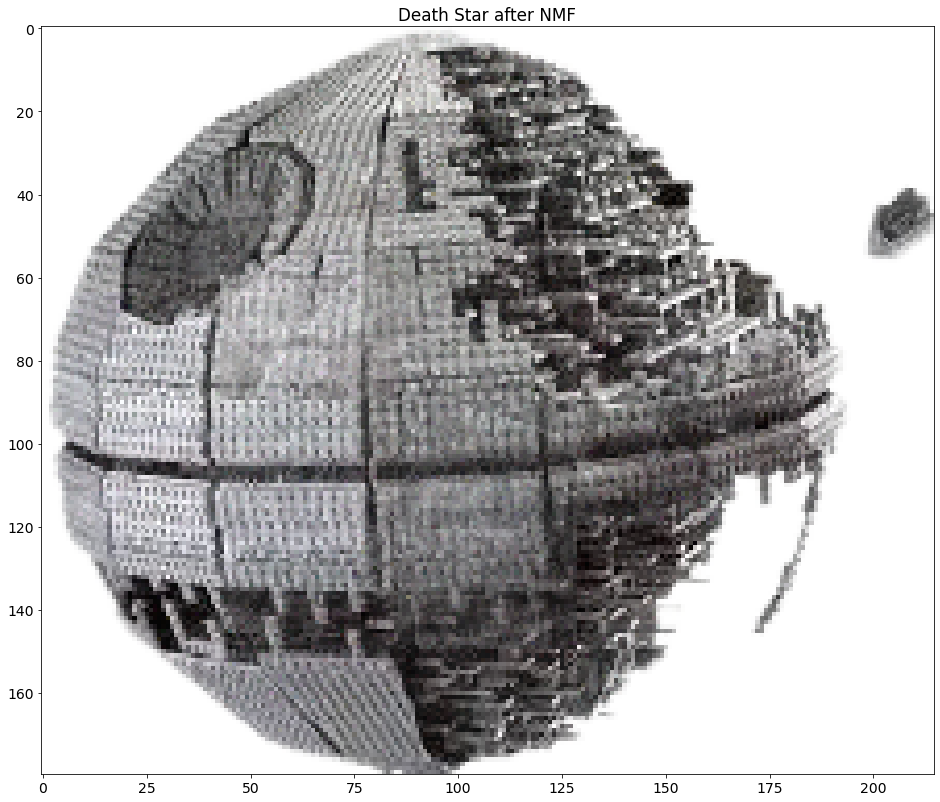

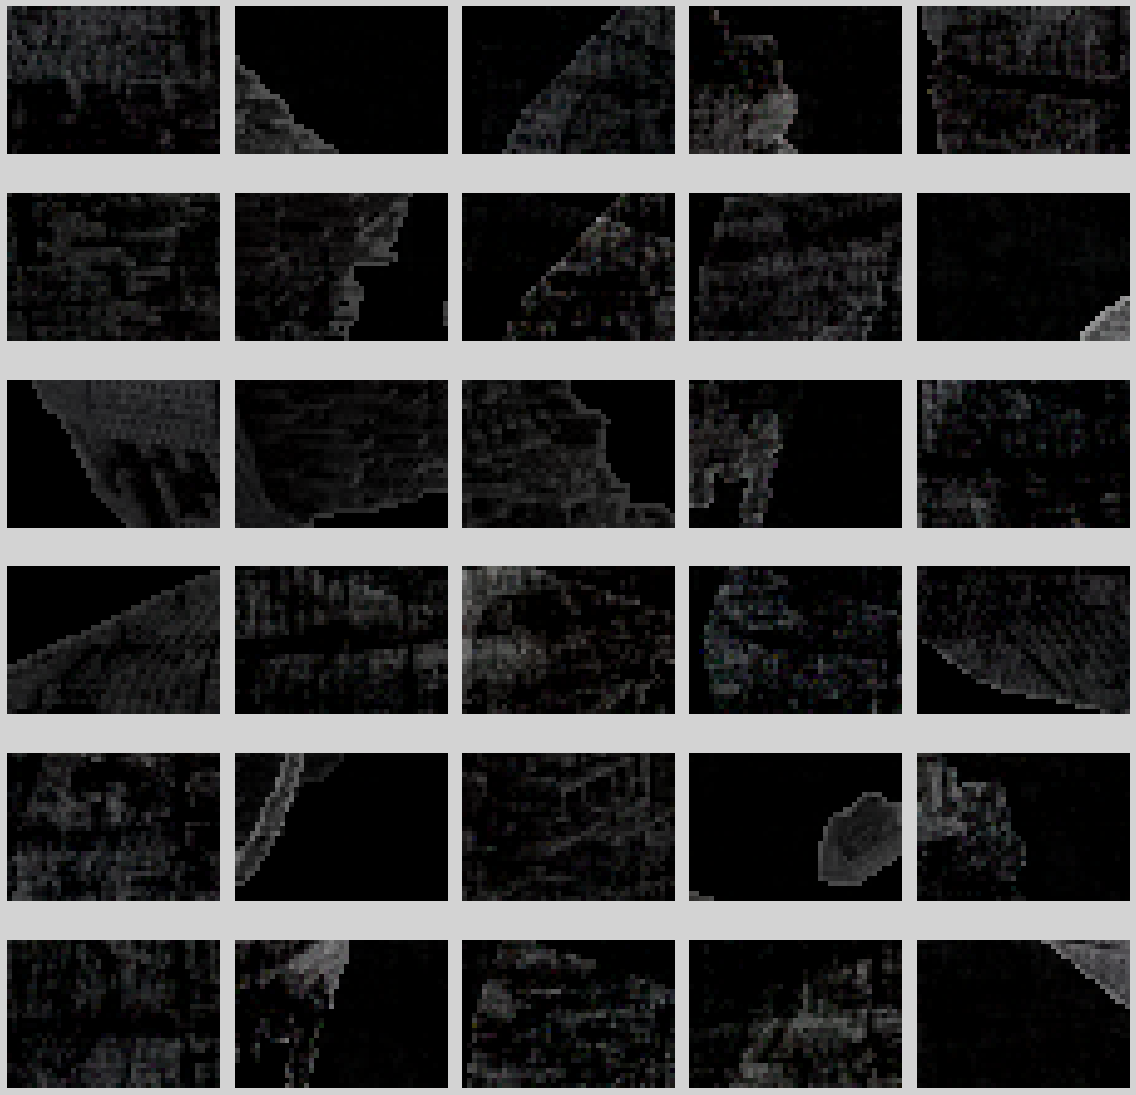

In [36]:
"""
We want to look at the resulting death star composed of the W and H as well as the "building blocks" in W

"""
deathopac = deathopac.reshape(180,215,1)

NMF_total_dstar = np.concatenate((NMF_clipped_dstar, deathopac), axis=2)    # Combining the opacity and RGB

plt.figure(figsize=(16,16))

plt.title('Death Star after NMF')
plt.imshow(NMF_total_dstar)
plt.show()

plotimgs_deathstar(np.reshape(W_dstar, (d_dstar,43,3,30)))

Here is the lego Death Star in all its glory, followed by $W$. The matrix $W$ is figuratively the lego-pieces and $H$ the instruction manual as we touched upon in the introductory analogy. The $W_{CryptoPunks}$ visibly contains the recurring features for the punks, but the $W_{Death Star}$ contains parts of the Death Star that are hard to recognize. This is likely due to the fact that the latter does not contain the same level of reccuring elements as the first does. However, the result when recombining $W$ and $H$ is much like with the CryptoPunks - just a bit blurry, and we will later on do some de-noising for a satisfactory result. But we did however obtain a resulting picture resembling the original, and also managed to save a lot of space. Now some calculations:

The total entries used by having the .png file in full: $180\cdot 215 \cdot 4 = 154800$, but by decomposing the matrix into $W$ and $H$ with $d = 30$ we use: $(180+215)\cdot30\cdot3 + 180\cdot 215 = 74250$ entries. This is $\approx 48\%$ of the total entries, which we deem worth doing, even though the results are mildly blurry. De-noising is up next.



In [37]:
# Reshaping the reconstruction
deathRGBparted_denoise = np.reshape(NMF_clipped_dstar[0:30,0:43,:], (30,43,3,1))

# Partitioning the reconstruction
for i in range(6):
    for j in range(5):       # These nested for loops save the data in such a way that it resembles the previous tasks
        if i != 0 or j != 0:
            deathRGBparted_denoise = np.concatenate((deathRGBparted_denoise,np.reshape(NMF_clipped_dstar[30*i:30*(i+1), 43*j:43*(j+1), :],(30,43,3,1))), axis = -1)

# Reshaping the partitioned reconstruction
deathRGBparted_denoise = np.reshape(deathRGBparted_denoise, (3870,30))

# Fitting an NMF to the reconstruction
H_denoised_dstar, W_denoised_dstar = LeeSeungsNMF(deathRGBparted_denoise, d_dstar, delta)

# Reconstructing de-noised image
NMF_denoised_dstar = W_denoised_dstar @ H_denoised_dstar
NMF_denoised_reshaped_dstar = NMF_denoised_dstar.reshape(30, 43, 3, 30)
for i in range(6):
    NMF_denoised_row = np.reshape(NMF_reshaped_dstar[:,:,:,i*5],(30,43,3))
    for j in range(1,5):
        NMF_denoised_row = np.concatenate((NMF_denoised_row,np.reshape(NMF_denoised_reshaped_dstar[:,:,:,i*5+j], (30,43,3))),axis = 1)
    if i == 0:
         NMF_denoised_puttogether = NMF_denoised_row
    else:
        NMF_denoised_puttogether = np.concatenate((NMF_denoised_puttogether,NMF_denoised_row),axis = 0)

# Clipping the de-noised image
NMF_denoised_clipped_dstar = np.where(NMF_denoised_puttogether < 1, NMF_denoised_puttogether, 1)

# Recombining the opacity layer to the clipped de-noised image
NMF_denoised_total_dstar = np.concatenate((NMF_denoised_clipped_dstar, deathopac), axis=2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

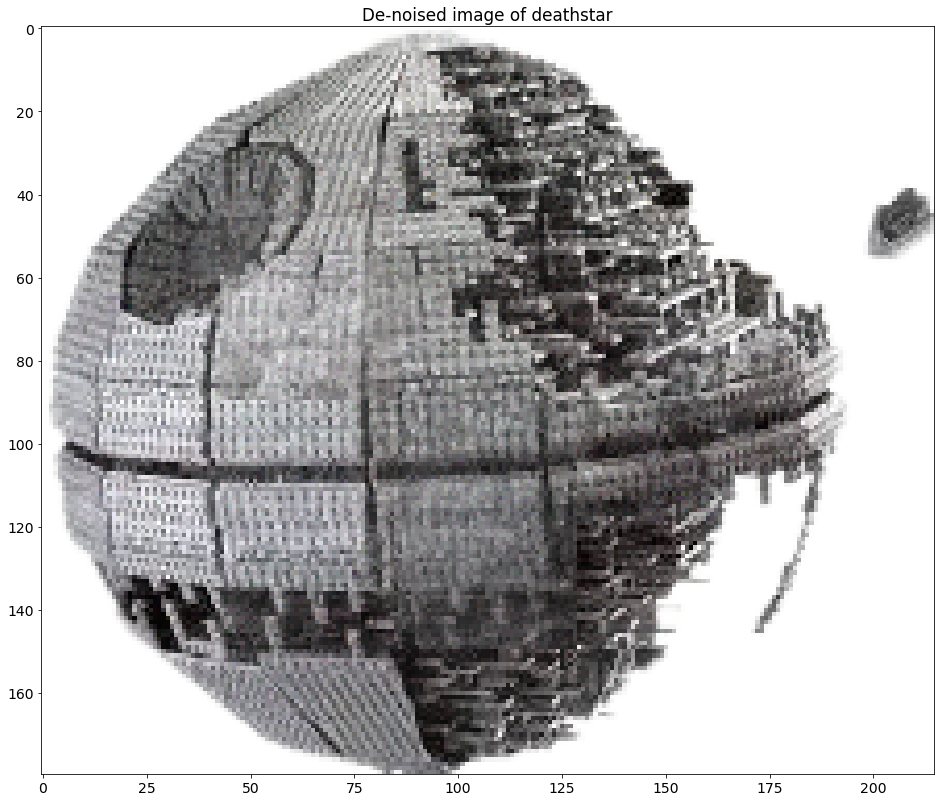

In [38]:
# Plotting de-noised image
plt.figure(figsize=(16, 16))
plt.title("De-noised image of deathstar")
plt.imshow(NMF_denoised_total_dstar)

# Calculating errors of NMF and de-noised NMF
norm_dstar = fro_norm(deathRGBparted, NMF_dstar)
norm_denoised_dstar = fro_norm(deathRGBparted, NMF_denoised_dstar)

# Printing errors
display(Latex(f"Norm between original Death Star and NMF before de-noising: ${norm_dstar}$"))
display(Latex(f"Norm between original Death Star and NMF after de-noising:  ${norm_denoised_dstar}$"))

Important to note about the calculated norms is that the opacity channels are not added for these calculations. This should in turn not matter because of the nature of the Frobenius norm. Since the opacity channels are the same for each image, including it in the calculations of the norms would just be adding countless zero-terms, meaning the norms would remain unchanged.

In this particular case, the de-noising turned out to be "noising", giving back an image with more error than before the NMF. The de-noising worked for the CryptoPunks as they were generally the same shape, but in this example they are not. We have now shown that with just a tiny touch of reshaping, a randomly chosen picture can be pushed through the algorithm, broken down into smaller components, and yet give a satisfactory result when reconstructed. This result is in line with our conclusion in 3d; the algorithm works for the Death Star, but we did not save as much space as with the CryptoPunks dataset.

## References:
Lindstrøm, T. L., & Hveberg, K. (2015). Flervariabel analyse med lineær algebra. Gyldendal akademisk.

-----

$^{\star}$ Note that the picture used is in fact the Death Star II and not the first one. 